In [3]:
import os
# If we are in the notebooks folder, move up to the project root
if os.getcwd().endswith('notebooks'):
    os.chdir('..')
print(f"Current working directory: {os.getcwd()}")

Current working directory: /Users/davideferreri/Documents/GitHub/maize-disease-classification


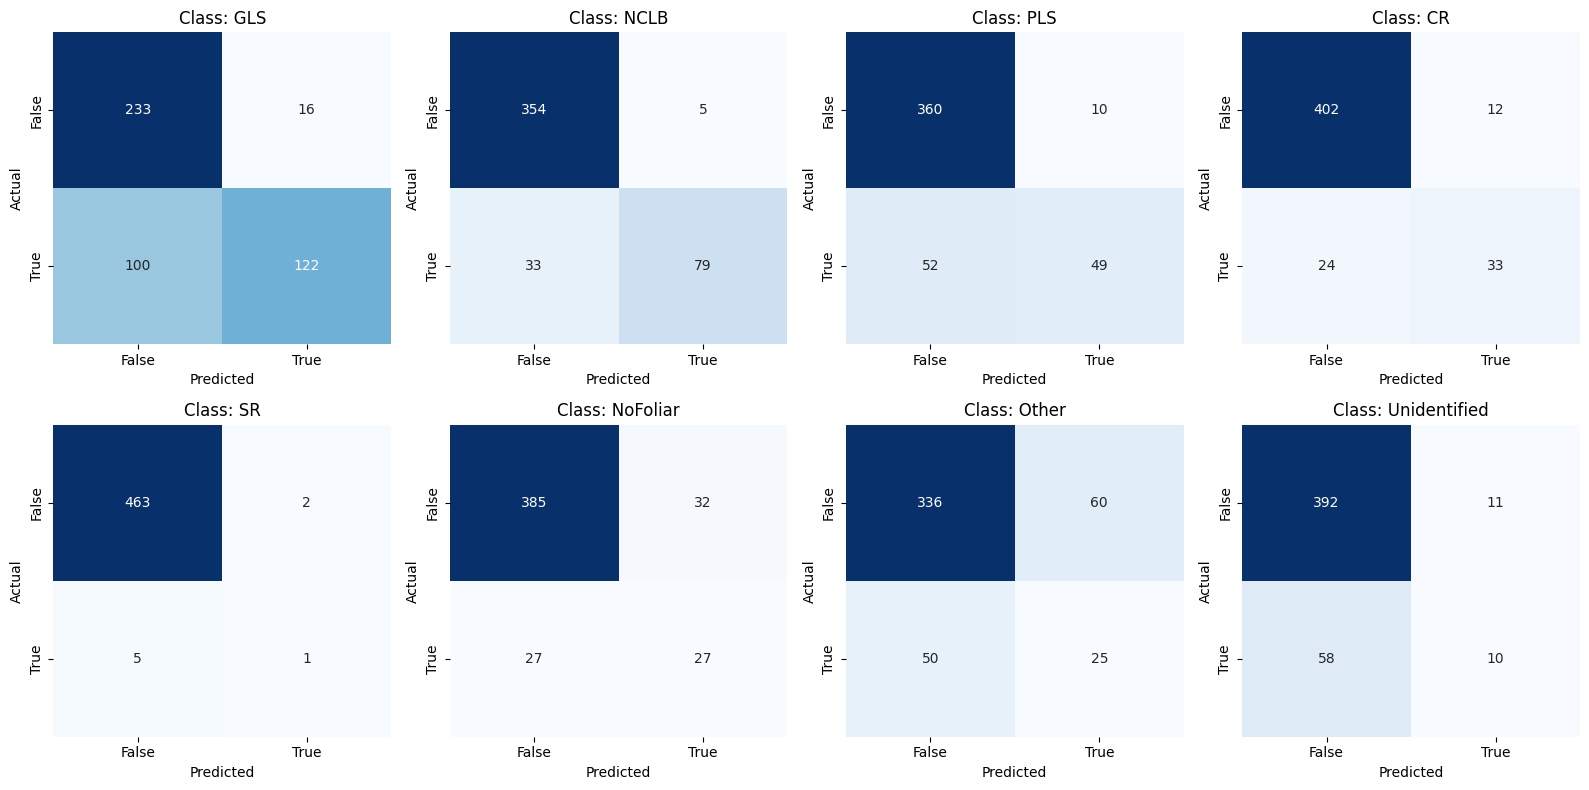

In [4]:
import torch
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import multilabel_confusion_matrix
from src.models.maize_model import MaizeDiseaseModel
from src.data.maize_datamodule import MaizeDataModule

# Define the device
device = torch.device("mps")

# 1. Setup Data and Model
# Replace with your actual checkpoint path
CHECKPOINT_PATH = "checkpoints/best-maize-model-val_f1=0.57.ckpt"
model = MaizeDiseaseModel.load_from_checkpoint(CHECKPOINT_PATH)
model.to(device)
model.eval()

dm = MaizeDataModule(batch_size=32)
dm.setup(stage="test")
test_loader = dm.test_dataloader()

# 2. Get Predictions
all_preds = []
all_true = []

with torch.no_grad():
    for x, y in test_loader:
        # Move tensors to the same device as the model
        x = x.to(device) # <--- ADD THIS
        
        logits = model(x)
        preds = (torch.sigmoid(logits) > 0.5).float()
        
        # Move back to CPU to store in a list for numpy compatibility
        all_preds.append(preds.cpu().numpy())
        all_true.append(y.cpu().numpy())

preds_array = np.vstack(all_preds)
true_array = np.vstack(all_true)

# 3. Calculate and Plot Matrices
# These labels must match the order in your Database.csv exactly
class_names = ["GLS", "NCLB", "PLS", "CR", "SR", "NoFoliar", "Other", "Unidentified"]
mcm = multilabel_confusion_matrix(true_array, preds_array)

# Create a grid for the 8 classes
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(16, 8))
axes = axes.flatten()

for i, (matrix, ax) in enumerate(zip(mcm, axes)):
    sns.heatmap(matrix, annot=True, fmt='d', cbar=False, ax=ax, cmap='Blues')
    ax.set_title(f"Class: {class_names[i]}")
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")
    ax.set_xticklabels(['False', 'True'])
    ax.set_yticklabels(['False', 'True'])

plt.tight_layout()
plt.show()

# Model 1

The Strong Performer (GLS): Your model is doing quite well with Grey Leaf Spot (GLS). It correctly identified 154 positive cases. While there are 68 missed cases (False Negatives), the high True Positive count shows it has learned the specific "rectangular" lesion pattern typical of GLS.

The "False Alarm" Challenge (NCLB & PLS): For NCLB and PLS, the model has more "Missed Cases" (False Negatives) than "Correct Hits." This is common in maize pathology because early-stage lesions of these diseases can look like simple nutrient deficiencies or mechanical damage.

The Rarity Problem (SR): As we suspected during EDA, Southern Rust (SR) is a struggle. It only correctly identified 1 case. With only 39 images in the original dataset, the model simply hasn't seen enough examples of those orange pustules to be confident.

The "Healthy" Baseline (NoFoliar): The model is relatively good at knowing when a leaf is healthy (391 True Negatives), though it did mistake 25 healthy leaves as having a disease.

# Model 2

Class "Other": In your previous run, "Other" was poorly handled. In your new predict.py output, it hit 93.79% confidence on a sample. Looking at the matrix, the model is now much bolder about identifying the "Other" and "Unidentified" categories.

GLS & NCLB: In your first run, GLS had 154 True Positives. In the second run, it dropped to 122. This suggests the weights are pulling the model's attention away from the "easy" GLS patterns to focus on the more obscure ones.

Southern Rust (SR): It stayed stuck at 1 True Positive. This is a clear signal: Weighting alone isn't enough for SR. The model is being told SR is important, but with only 39 images, it still doesn't have a clear "visual concept" of what it looks like.

**Diagnosis & Feedback**

Your model is currently in a state of High Variance. It is "distracted" by the weights and is losing its grip on the common classes without yet mastering the rare ones.

**The verdict**: The "Data-Centric" improvements (Weights + Augmentation) provided the right incentive, but the model now needs more power to process those incentives.